<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [54]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim.models.coherencemodel import CoherenceModel


#for histogram
import matplotlib.pyplot as plt
from collections import Counter


#nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize


# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Spacy
import spacy


#Dataset
from sklearn.datasets import fetch_20newsgroups


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data into Dataframe

In [55]:
#method that converts data to csv file
def twenty_newsgroup_data_to_csv():
    news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

    df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
    df.columns = ['text', 'target']

    targets = pd.DataFrame( news_group_data.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_newsgroup.csv')
twenty_newsgroup_data_to_csv()

In [56]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)


In [57]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1474
text          1474
target        1474
title         1474
dtype: int64


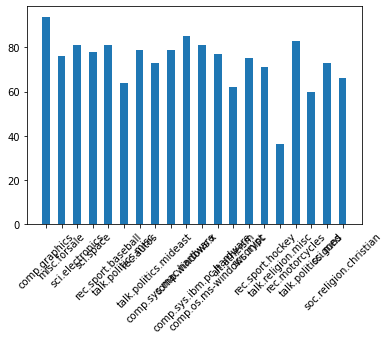

In [58]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [59]:
print(counter)

Counter({'comp.graphics': 94, 'comp.windows.x': 85, 'rec.motorcycles': 83, 'sci.electronics': 81, 'rec.sport.baseball': 81, 'comp.sys.ibm.pc.hardware': 81, 'rec.autos': 79, 'comp.sys.mac.hardware': 79, 'sci.space': 78, 'comp.os.ms-windows.misc': 77, 'misc.forsale': 76, 'sci.crypt': 75, 'talk.politics.mideast': 73, 'sci.med': 73, 'rec.sport.hockey': 71, 'soc.religion.christian': 66, 'talk.politics.misc': 64, 'alt.atheism': 62, 'talk.politics.guns': 60, 'talk.religion.misc': 36})


## Pre-process data

Lemmatization to get base words

In [77]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [78]:
dataset['news_lemma_text']=lemmatization(dataset['text'])


In [79]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_cleaned_text,news_tokens,news_lemma_text
0,11186,\n > \n > I am looking for an algorithm to d...,1,comp.graphics,look algorithm determine give point bind polyg...,"[look, algorithm, determine, give, point, bind...",look algorithm determine give point bind polyg...
1,5799,I finally got a 24 bit viewer for my POVRAY ge...,1,comp.graphics,finally get bit viewer povray generate .tga fi...,"[finally, get, bit, viewer, povray, generate, ...",finally get bit viewer povray generate .tga fi...
2,8627,"Up until last week, I have been running POVray...",1,comp.graphics,last week run major problem increase memory fi...,"[last, week, run, major, problem, increase, me...",last week run major problem increase memory fi...
3,10871,What hardware do plan to run on? Workstation ...,1,comp.graphics,hardware plan run workstation pc cost level ru...,"[hardware, plan, run, workstation, cost, level...",hardware plan run workstation pc cost level ru...
4,7454,/*\n\nThis program doesn't detect edges with c...,1,comp.graphics,program detect edge compass operator laplacian...,"[program, detect, edge, compass, operator, lap...",program detect edge compass operator laplacian...
5,7568,Visual Numerics Inc. (formerly IMSL and Precis...,1,comp.graphics,formerly process secure site beta testing prod...,"[formerly, process, secure, site, beta, testin...",formerly process secure site beta testing prod...
6,1715,Hi.\n\nThe RTrace ray tracer supports 3D text ...,1,comp.graphics,ray support text primitive collection sphere c...,"[ray, support, text, primitive, collection, sp...",ray support text primitive collection sphere c...
7,9413,"Hello, I am looking for commercial software pa...",1,comp.graphics,look commercial software package professional ...,"[look, commercial, software, package, professi...",look commercial software package professional ...
8,3503,"Hi again,\n\nMany thanks to all the people who...",1,comp.graphics,again many thank people respond request screen...,"[many, thank, people, respond, request, screen...",again many thank people respond request screen...
9,7826,\nA brilliant algorithm. *NOT*\n\nSeriously -...,1,comp.graphics,brilliant algorithm not seriously correct sign...,"[brilliant, algorithm, seriously, correct, sig...",brilliant algorithm not seriously correct sign...


Remove Stopword

In [80]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [81]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_cleaned_text'])

In [82]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_cleaned_text,news_tokens,news_lemma_text
0,11186,\n > \n > I am looking for an algorithm to d...,1,comp.graphics,look algorithm determine give point bind polyg...,"[look, algorithm, determine, give, point, bind...",look algorithm determine give point bind polyg...
1,5799,I finally got a 24 bit viewer for my POVRAY ge...,1,comp.graphics,finally get bit viewer povray generate .tga fi...,"[finally, get, bit, viewer, povray, generate, ...",finally get bit viewer povray generate .tga fi...
2,8627,"Up until last week, I have been running POVray...",1,comp.graphics,last week run major problem increase memory fi...,"[last, week, run, major, problem, increase, me...",last week run major problem increase memory fi...
3,10871,What hardware do plan to run on? Workstation ...,1,comp.graphics,hardware plan run workstation pc cost level ru...,"[hardware, plan, run, workstation, cost, level...",hardware plan run workstation pc cost level ru...
4,7454,/*\n\nThis program doesn't detect edges with c...,1,comp.graphics,program detect edge compass operator laplacian...,"[program, detect, edge, compass, operator, lap...",program detect edge compass operator laplacian...
5,7568,Visual Numerics Inc. (formerly IMSL and Precis...,1,comp.graphics,formerly process secure site beta testing prod...,"[formerly, process, secure, site, beta, testin...",formerly process secure site beta testing prod...
6,1715,Hi.\n\nThe RTrace ray tracer supports 3D text ...,1,comp.graphics,ray support text primitive collection sphere c...,"[ray, support, text, primitive, collection, sp...",ray support text primitive collection sphere c...
7,9413,"Hello, I am looking for commercial software pa...",1,comp.graphics,look commercial software package professional ...,"[look, commercial, software, package, professi...",look commercial software package professional ...
8,3503,"Hi again,\n\nMany thanks to all the people who...",1,comp.graphics,again many thank people respond request screen...,"[many, thank, people, respond, request, screen...",again many thank people respond request screen...
9,7826,\nA brilliant algorithm. *NOT*\n\nSeriously -...,1,comp.graphics,brilliant algorithm not seriously correct sign...,"[brilliant, algorithm, seriously, correct, sig...",brilliant algorithm not seriously correct sign...


In [83]:
def joinTokens(texts):
  texts_out = []
  for text in texts:
    new_text = []
    for token in text:
            new_text.append(token)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [84]:
dataset['news_joined_text']=joinTokens(dataset['news_tokens'])

In [85]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_cleaned_text,news_tokens,news_lemma_text,news_joined_text
0,11186,\n > \n > I am looking for an algorithm to d...,1,comp.graphics,look algorithm determine give point bind polyg...,"[look, algorithm, determine, give, point, bind...",look algorithm determine give point bind polyg...,look algorithm determine give point bind polyg...
1,5799,I finally got a 24 bit viewer for my POVRAY ge...,1,comp.graphics,finally get bit viewer povray generate .tga fi...,"[finally, get, bit, viewer, povray, generate, ...",finally get bit viewer povray generate .tga fi...,finally get bit viewer povray generate tga fil...
2,8627,"Up until last week, I have been running POVray...",1,comp.graphics,last week run major problem increase memory fi...,"[last, week, run, major, problem, increase, me...",last week run major problem increase memory fi...,last week run major problem increase memory fi...
3,10871,What hardware do plan to run on? Workstation ...,1,comp.graphics,hardware plan run workstation pc cost level ru...,"[hardware, plan, run, workstation, cost, level...",hardware plan run workstation pc cost level ru...,hardware plan run workstation cost level run t...
4,7454,/*\n\nThis program doesn't detect edges with c...,1,comp.graphics,program detect edge compass operator laplacian...,"[program, detect, edge, compass, operator, lap...",program detect edge compass operator laplacian...,program detect edge compass operator laplacian...
5,7568,Visual Numerics Inc. (formerly IMSL and Precis...,1,comp.graphics,formerly process secure site beta testing prod...,"[formerly, process, secure, site, beta, testin...",formerly process secure site beta testing prod...,formerly process secure site beta testing prod...
6,1715,Hi.\n\nThe RTrace ray tracer supports 3D text ...,1,comp.graphics,ray support text primitive collection sphere c...,"[ray, support, text, primitive, collection, sp...",ray support text primitive collection sphere c...,ray support text primitive collection sphere c...
7,9413,"Hello, I am looking for commercial software pa...",1,comp.graphics,look commercial software package professional ...,"[look, commercial, software, package, professi...",look commercial software package professional ...,look commercial software package professional ...
8,3503,"Hi again,\n\nMany thanks to all the people who...",1,comp.graphics,again many thank people respond request screen...,"[many, thank, people, respond, request, screen...",again many thank people respond request screen...,many thank people respond request screen grabb...
9,7826,\nA brilliant algorithm. *NOT*\n\nSeriously -...,1,comp.graphics,brilliant algorithm not seriously correct sign...,"[brilliant, algorithm, seriously, correct, sig...",brilliant algorithm not seriously correct sign...,brilliant algorithm seriously correct sign cha...


## Term-document matrix

In [91]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)

In [92]:
vect_text=vect.fit_transform(dataset['news_joined_text'])

In [93]:
print(vect_text)

  (0, 758)	0.30265910803849894
  (0, 270)	0.2821518799619311
  (0, 434)	0.2638731692491544
  (0, 175)	0.323566997713172
  (0, 99)	0.28326613864382666
  (0, 731)	0.3177014637347521
  (0, 146)	0.3057237773853435
  (0, 651)	0.22424981453019155
  (0, 373)	0.212272128180783
  (0, 228)	0.33227730465954725
  (0, 26)	0.3644272883370323
  (0, 502)	0.2031238161336793
  (1, 910)	0.1282493404980726
  (1, 151)	0.1759880147914628
  (1, 921)	0.10563368643113306
  (1, 365)	0.18654146630475266
  (1, 956)	0.1596595401547019
  (1, 737)	0.18880385828344973
  (1, 526)	0.3414911379546885
  (1, 65)	0.20097443600853807
  (1, 84)	0.13422493739362273
  (1, 686)	0.295438362531031
  (1, 991)	0.11926609987113121
  (1, 959)	0.18654146630475266
  (1, 700)	0.1804400153000338
  :	:
  (1472, 416)	0.28945142167601046
  (1472, 374)	0.30990516592798106
  (1472, 817)	0.3042788239165401
  (1473, 134)	0.3179579806221106
  (1473, 738)	0.4444952032521114
  (1473, 83)	0.1481650677507038
  (1473, 861)	0.134770601667584
  (1473, 

## Single Value Decompostion


In [103]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=42)

## Topic Encoded Data

In [104]:
lsa_top=lsa_model.fit_transform(vect_text)
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  12.115701352136247
Topic  1  :  4.11142729116312
Topic  2  :  -1.8954125874200174
Topic  3  :  6.637521626043597
Topic  4  :  0.677555320036511
Topic  5  :  -10.82086573125832
Topic  6  :  -0.1115290030171967
Topic  7  :  -8.239248004511765
Topic  8  :  5.483333906106902
Topic  9  :  -0.32088397081673087
Topic  10  :  6.189082693201078
Topic  11  :  -6.52475109835559
Topic  12  :  0.8508066211024429
Topic  13  :  1.6423661730349444
Topic  14  :  10.535672915679525
Topic  15  :  13.077451381049007
Topic  16  :  1.602558406610111
Topic  17  :  0.8578854306263997
Topic  18  :  -2.517035296827173
Topic  19  :  10.850322871146034


Words Associated with the topic

In [105]:
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         

Topic 0: 
know think good say get make see could time may 

Topic 1: 
file window card thank program driver problem drive mail help 

Topic 2: 
game team play win run player season score last good 

Topic 3: 
key file game program team window send play chip group 

Topic 4: 
key drive chip system card phone keyboard car escrow number 

Topic 5: 
file drive window problem key run get time disk change 

Topic 6: 
window driver card screen run color system display application monitor 

Topic 7: 
know driver card say post game drive key could see 

Topic 8: 
look driver car card good key see work file know 

Topic 9: 
window thank good key know get post could bike advance 

Topic 10: 
look window card see color monitor call screen drive think 

Topic 11: 
get post see mail take address email problem new think 

Topic 12: 
say year good driver post tell look window address want 

Topic 13: 
think post make see could version really drive like driver 

Topic 14: 
look could post year find win

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
